#Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET

# EDA

In [ ]:
# Import dataset
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1eATPANxt4PQ8lKx3SNDz7HdjjCCwpv0J' -O data.zip
!unzip data.zip

--2025-03-01 17:21:31--  https://drive.google.com/uc?export=download&id=1eATPANxt4PQ8lKx3SNDz7HdjjCCwpv0J
Resolving drive.google.com (drive.google.com)... 74.125.200.138, 74.125.200.139, 74.125.200.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.200.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eATPANxt4PQ8lKx3SNDz7HdjjCCwpv0J&export=download [following]
--2025-03-01 17:21:32--  https://drive.usercontent.google.com/download?id=1eATPANxt4PQ8lKx3SNDz7HdjjCCwpv0J&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.130.132, 2404:6800:4003:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.130.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17351887 (17M) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]  16.55M  54.5MB/s    in

In [ ]:
images_dir = ''
annotations_dir = 'damaged_car_dataset/bounding_box_annotations'
data = pd.read_csv('damaged_car_dataset/category_annotations/index.csv')
data.head()

,image,class,subset
0,image/0.jpeg,unknown,T
1,image/1.jpeg,head_lamp,T
2,image/2.jpeg,door_scratch,T
3,image/3.jpeg,head_lamp,T
4,image/4.jpeg,unknown,T


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1594 entries, 0 to 1593
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1594 non-null   object
 1   class   1594 non-null   object
 2   subset  1594 non-null   object
dtypes: object(3)
memory usage: 37.5+ KB


In [ ]:
data.isnull().sum()

,0
image,0
class,0
subset,0


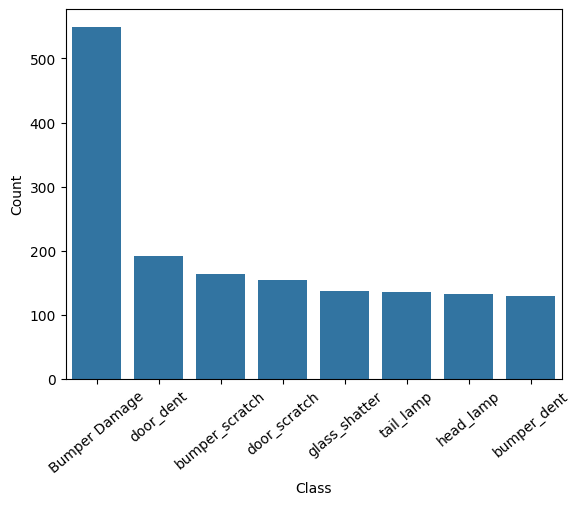

In [ ]:
counts = data['class'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=40);

In [ ]:
path ='damaged_car_dataset/'
def edit_path_img(x):
    return path + x

In [ ]:
data["class"].unique()

array(['unknown', 'head_lamp', 'door_scratch', 'glass_shatter',
       'tail_lamp', 'bumper_dent', 'door_dent', 'bumper_scratch'],
      dtype=object)

In [ ]:
data["image"] = data["image"].apply(edit_path_img)

data.head()

,image,class,subset
0,damaged_car_dataset/image/0.jpeg,unknown,T
1,damaged_car_dataset/image/1.jpeg,head_lamp,T
2,damaged_car_dataset/image/2.jpeg,door_scratch,T
3,damaged_car_dataset/image/3.jpeg,head_lamp,T
4,damaged_car_dataset/image/4.jpeg,unknown,T


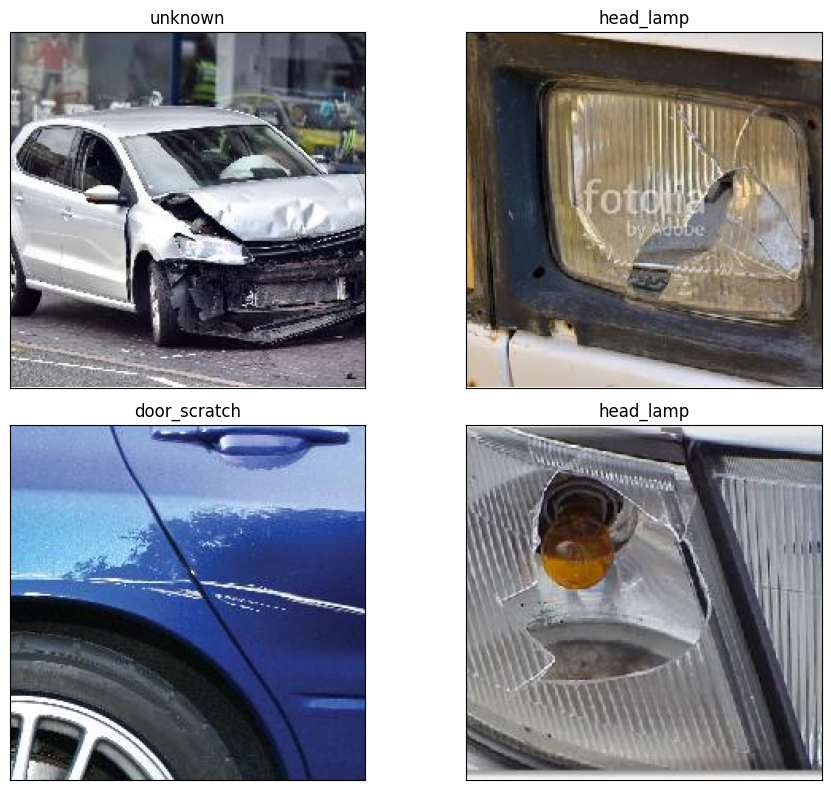

In [ ]:
datafig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.image[i]))
    ax.set_title(data['class'][i])
plt.tight_layout()
plt.show()

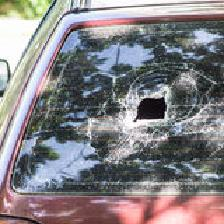

In [ ]:
sample_image = Image.open(data.image[1032])

sample_image


In [ ]:
with open('damaged_car_dataset/bounding_box_annotations/1032.xml') as annot_file:
    print(''.join(annot_file.readlines()))

<annotation>
	<folder>image</folder>
	<filename>1032.jpeg</filename>
	<path>/home/purna/Downloads/preprocessed/image/1032.jpeg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>224</width>
		<height>224</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>damage</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>92</xmin>
			<ymin>62</ymin>
			<xmax>224</xmax>
			<ymax>173</ymax>
		</bndbox>
	</object>
</annotation>



In [ ]:
tree = ET.parse('damaged_car_dataset/bounding_box_annotations/1032.xml')
root = tree.getroot()

sample_annotations = []

for neighbor in root.iter('bndbox'):
    xmin = int(neighbor.find('xmin').text)
    ymin = int(neighbor.find('ymin').text)
    xmax = int(neighbor.find('xmax').text)
    ymax = int(neighbor.find('ymax').text)

#     print(xmin, ymin, xmax, ymax)
    sample_annotations.append([xmin, ymin, xmax, ymax])
print(sample_annotations)

[[92, 62, 224, 173]]


[92, 62, 224, 173]


Text(0.5, 1.0, 'glass_shatter')

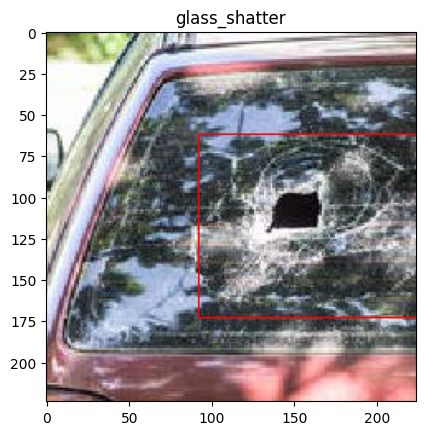

In [ ]:

sample_image_annotated = sample_image.copy()
img_bbox =ImageDraw.Draw(sample_image_annotated)
for bbox in sample_annotations:
    print(bbox)
    #print(data.classes[1032])
    img_bbox.rectangle(bbox, outline="red")
#sample_image_annotated
plt.imshow(sample_image_annotated)
plt.title(data['class'][1032])

# Data Augmentation

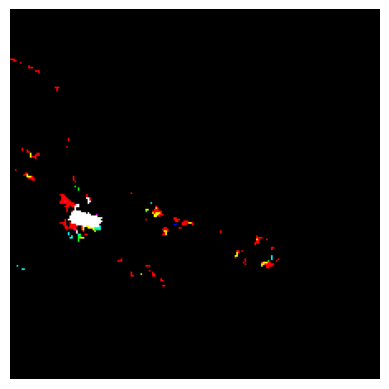

In [ ]:
image_path = "damaged_car_dataset/image/0.jpeg"
image = cv2.imread(image_path)

# Resize the image to a standard size (224x224)
image_resized = cv2.resize(image, (224, 224))

# Normalize pixel values to range [0,1]
image_normalized = image_resized / 255.0

# Apply Augmentations using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2
)

# Expand dimension (to make it batch-compatible)
image_expanded = np.expand_dims(image_normalized, axis=0)

# Generate augmented images
aug_iter = datagen.flow(image_expanded, batch_size=1)

# Display the transformed image
augmented_image = next(aug_iter)[0]  # Get first batch image
plt.imshow(augmented_image)
plt.axis('off')
plt.show()

# CNN Model

In [ ]:
xml_dir = 'damaged_car_dataset/bounding_box_annotations'

In [ ]:
# Function to extract bounding boxes from XML
def get_bounding_box(xml_file, img_width, img_height):
    xml_path = os.path.join(xml_dir, xml_file.split('/')[2])

    if not os.path.exists(xml_path):
        print(f"XML file not found: {xml_path}")
        return None

    tree = ET.parse(xml_path)
    root = tree.getroot()

    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        x_min = int(bbox.find('xmin').text) / img_width
        y_min = int(bbox.find('ymin').text) / img_height
        x_max = int(bbox.find('xmax').text) / img_width
        y_max = int(bbox.find('ymax').text) / img_height

        return [x_min, y_min, x_max, y_max]  # Normalized

    return None  # If no bounding box is found

In [ ]:
# Data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2
)

# Function to load, preprocess, and augment an image
def process_and_augment_image(image_name):
    image_path = os.path.join(images_dir, image_name)

    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None, None

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_height, img_width, _ = image.shape

    # Resize & normalize
    image_resized = cv2.resize(image, (224, 224)) / 255.0

    # Get bounding box
    xml_file = image_name.replace('.jpeg', '.xml')
    bbox = get_bounding_box(xml_file, img_width, img_height)
    if bbox is None:
        return None, None

    # Expand dimension for batch processing
    image_expanded = np.expand_dims(image_resized, axis=0)

    # Apply augmentation
    aug_iter = datagen.flow(image_expanded, batch_size=1)
    augmented_image = next(aug_iter)[0]

    return augmented_image, bbox


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Label Encoding for class labels
label_encoder = LabelEncoder()
data["class_encoded"] = label_encoder.fit_transform(data["class"])  # Convert class names to numeric labels

X, y_class, y_bbox = [], [], []

for i in range(len(data)):
    image_name = data.loc[i, "image"]
    class_label = data.loc[i, "class_encoded"]  # Get the label-encoded class
    image, bbox = process_and_augment_image(image_name)

    if image is not None:
        X.append(image)
        y_class.append(class_label)
        y_bbox.append(bbox)

# Convert lists to numpy arrays
X = np.array(X)
y_class = np.array(y_class)  # Now a 1D array of integer labels
y_bbox = np.array(y_bbox)

# Split into train & test sets
X_train, X_test, y_class_train, y_class_test, y_bbox_train, y_bbox_test = train_test_split(
    X, y_class, y_bbox, test_size=0.2, random_state=42
)

print(f"Train Set: {X_train.shape}, {y_class_train.shape}, {y_bbox_train.shape}")
print(f"Test Set: {X_test.shape}, {y_class_test.shape}, {y_bbox_test.shape}")

XML file not found: damaged_car_dataset/bounding_box_annotations/23.xml
XML file not found: damaged_car_dataset/bounding_box_annotations/38.xml
XML file not found: damaged_car_dataset/bounding_box_annotations/43.xml
XML file not found: damaged_car_dataset/bounding_box_annotations/48.xml
XML file not found: damaged_car_dataset/bounding_box_annotations/54.xml
XML file not found: damaged_car_dataset/bounding_box_annotations/57.xml
XML file not found: damaged_car_dataset/bounding_box_annotations/73.xml
XML file not found: damaged_car_dataset/bounding_box_annotations/75.xml
XML file not found: damaged_car_dataset/bounding_box_annotations/79.xml
XML file not found: damaged_car_dataset/bounding_box_annotations/80.xml
XML file not found: damaged_car_dataset/bounding_box_annotations/84.xml
XML file not found: damaged_car_dataset/bounding_box_annotations/91.xml
XML file not found: damaged_car_dataset/bounding_box_annotations/99.xml
XML file not found: damaged_car_dataset/bounding_box_annotations

# Model Summary

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
import tensorflow as tf

# Define input shape
input_shape = (224, 224, 3)

# Define Input Layer
inputs = Input(shape=input_shape)

# Base CNN Model
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output for classification (Multiclass classification using Label Encoding)
num_classes = len(set(y_class))  # Get number of unique class labels
class_output = Dense(num_classes, activation='softmax', name='class_output')(x)

# Output for bounding box coordinates
bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(x)

# Define the model with both outputs
model = Model(inputs=inputs, outputs=[class_output, bbox_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'class_output': 'sparse_categorical_crossentropy',  # Use sparse categorical crossentropy
                    'bbox_output': tf.keras.losses.MeanSquaredError()},
              metrics={'class_output': 'accuracy',
                       'bbox_output': tf.keras.metrics.MeanSquaredError()})

# Print model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 224, 224, 32)   │            896 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 112, 112, 32)   │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 56, 56, 64)     │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 28, 28, 128)    │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 100352)         │              0 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │     25,690,368 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class_output (Dense)      │ (None, 8)              │          2,056 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bbox_output (Dense)       │ (None, 4)              │          1,028 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,786,700 (98.37 MB)

 Trainable params: 25,786,700 (98.37 MB)

 Non-trainable params: 0 (0.00 B)

# Trainig the model

In [ ]:
# Train the model
model.fit(X_train,
          {'class_output': y_class_train, 'bbox_output': y_bbox_train},
          validation_data=(X_test, {'class_output': y_class_test, 'bbox_output': y_bbox_test}),
          epochs=10, batch_size=8)

# Save the model
model.save('car_damage_detector.h5')

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - bbox_output_loss: 0.0659 - bbox_output_mean_squared_error: 0.0659 - class_output_accuracy: 0.1570 - class_output_loss: 2.1251 - loss: 2.1910 - val_bbox_output_loss: 0.0266 - val_bbox_output_mean_squared_error: 0.0266 - val_class_output_accuracy: 0.1833 - val_class_output_loss: 2.0711 - val_loss: 2.0948
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - bbox_output_loss: 0.0352 - bbox_output_mean_squared_error: 0.0352 - class_output_accuracy: 0.2044 - class_output_loss: 2.0541 - loss: 2.0893 - val_bbox_output_loss: 0.0276 - val_bbox_output_mean_squared_error: 0.0276 - val_class_output_accuracy: 0.1873 - val_class_output_loss: 2.0902 - val_loss: 2.1167
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - bbox_output_loss: 0.0365 - bbox_output_mean_squared_error: 0.0365 - class_output_accuracy: 0.1937 - class_output_loss: 2.0142 - loss: 2.0508 - val_bbox_output_loss: 0.0523 - val_bbox_output_mean_squared_error: 0.0526 - val_cla

In [ ]:
# Load the trained model
model = tf.keras.models.load_model('car_damage_detector.h5')

# Testing the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


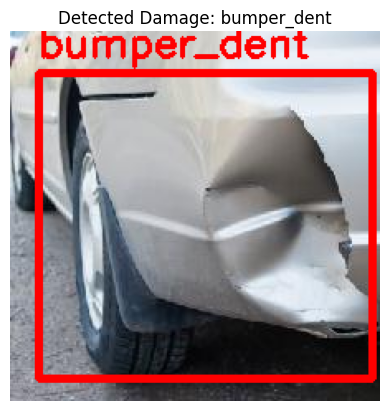

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Set the image directory
image_dir = "damaged_car_dataset/image"

# Function to preprocess image
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image = img_to_array(image) / 255.0  # Normalize pixel values
    return image

# Function to test a new image
def test_image(image_name, model, label_encoder):
    image_path = os.path.join(image_dir, image_name)

    if not os.path.exists(image_path):
        print(f"Error: Image not found - {image_path}")
        return

    # Load & preprocess the image
    processed_image = preprocess_image(image_path)

    # Predict class label & bounding box
    pred_class, pred_bbox = model.predict(np.expand_dims(processed_image, axis=0))

    # Decode predicted class
    class_index = np.argmax(pred_class[0])  # Get the index of highest probability
    predicted_label = label_encoder.inverse_transform([class_index])[0]  # Convert index to label

    # Convert bounding box output (normalized)
    x_min, y_min, x_max, y_max = pred_bbox[0]

    # Load the original image for visualization
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get image dimensions
    img_height, img_width, _ = image.shape

    # Convert bounding box coordinates back to original scale
    x_min, x_max = int(x_min * img_width), int(x_max * img_width)
    y_min, y_max = int(y_min * img_height), int(y_max * img_height)

    # Draw the bounding box
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 3)
    cv2.putText(image, predicted_label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    # Show result
    plt.imshow(image)
    plt.title(f"Detected Damage: {predicted_label}")
    plt.axis('off')
    plt.show()

# Test on a sample image
test_image("9.jpeg", model, label_encoder)  # Image should be in 'damaged_car_dataset/image'

# Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get model predictions
y_pred_crash, y_pred_bbox = model.predict(X_test)

# Convert probabilities to class labels (for multi-class classification)
y_pred_classes = np.argmax(y_pred_crash, axis=1)  # Get highest probability index
y_true_classes = y_class_test  # Already encoded as integers

# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Bounding box error (Mean Squared Error for bounding box prediction)
bbox_mse = np.mean(np.square(y_pred_bbox - y_bbox_test))
print("\nBounding Box MSE:", bbox_mse)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.10      0.11        21
           1       0.20      0.04      0.06        28
           2       0.00      0.00      0.00        37
           3       0.12      0.06      0.08        32
           4       0.25      0.03      0.05        36
           5       0.00      0.00      0.00        22
           6       0.14      0.07      0.10        28
           7       0.17      0.68      0.28        47

    accuracy                           0.16       251
   macro avg       0.13      0.12      0.08       251
weighted avg       0.13      0.16      0.10       251


Confusion Matrix:
[[ 2  0  0  1  0  0  0 18]
 [ 2  1  1  2  0  0  0 22]
 [ 1  0  0  2  0  0  1 33]
 [ 3  2  1  2  2  0  2 20]
 [ 4  0  0  6  1  0  1 24]
 [ 1  0  1  1  0  0  3 16]
 [ 1  1  3  1  1  1  2 18]
 [ 1  1  4  2  0  2  5 32]]

Bounding Box MSE: 0.04000071637056739
